# Notebook for analyzing the results

In this notebook we analyze the results from the experiments we ran. 

In [1]:
import json
import pandas as pd
from pathlib import Path
from bnsl.scoring import compute_shd

Store the records as a dataframe

In [2]:
root = Path.cwd().parents[1]    # two levels up
files = list((root / "data" / "results").rglob("*.json"))

In [3]:
records = []
for f in files:
    with open(f) as fp:
        r = json.load(fp)
        record = {
            "algorithm": r["algorithm"],
            "network": r["network"].split("/")[-1].split(".")[0],
            "num_samples": r["num_samples"],
            "score": r["score"],
            "optimal_upper_bound": r["params"].get("optimal_upper_bound"),
            "runtime": r["seconds_elapsed"],
            "k": r["params"].get("k"),
            "l": r["params"].get("l"),
            "num_vars": r["num_variables"],
            "seed": r["seed"],
            "parent_map": r.get("parent_map"),
        }
        records.append(record)

df = pd.DataFrame(records)

In [4]:
df.head()

,algorithm,network,num_samples,score,optimal_upper_bound,runtime,k,l,num_vars,seed,parent_map
0,silander_myllymaki,survey,100,-423.143,NaN,0.000,NaN,NaN,6,42,"{'A': [], 'E': ['A'], 'O': [], 'R': [], 'S': [..."
1,silander_myllymaki,asia,10000,-22193.508,NaN,0.002,NaN,NaN,8,44,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro..."
2,silander_myllymaki,survey,1000,-4033.283,NaN,0.000,NaN,NaN,6,44,"{'A': ['E'], 'E': [], 'O': [], 'R': [], 'S': [..."
3,silander_myllymaki,survey,10000,-39569.183,NaN,0.000,NaN,NaN,6,44,"{'A': ['E'], 'E': ['O', 'R'], 'O': ['T'], 'R':..."
4,silander_myllymaki,sachs,100,-869.895,NaN,0.017,NaN,NaN,11,42,"{'Akt': ['Mek'], 'Erk': ['Akt'], 'Jnk': ['PKA'..."


 Create a table with only approximation algorithm, and true fields from dp

In [5]:
approx_df = df[df["algorithm"] == "approximation_algorithm"].drop(columns=["algorithm"])

In [6]:
# apply the true score from silander myllymaki to the corresponding approximation results
approx_df["dp_score"] = approx_df.apply(
    lambda row: df[
        (df["algorithm"] == "silander_myllymaki") &
        (df["network"] == row["network"]) &
        (df["num_samples"] == row["num_samples"]) &
        (df["seed"] == row["seed"])
    ]["score"].values[0], axis=1
)

In [7]:
# apply the true pm from silander myllymaki to the corresponding approximation results
approx_df["dp_parent_map"] = approx_df.apply(
    lambda row: df[
        (df["algorithm"] == "silander_myllymaki") &
        (df["network"] == row["network"]) &
        (df["num_samples"] == row["num_samples"]) &
        (df["seed"] == row["seed"])
    ]["parent_map"].values[0], axis=1
)

In [8]:
approx_df.head()

,network,num_samples,score,optimal_upper_bound,runtime,k,l,num_vars,seed,parent_map,dp_score,dp_parent_map
45,asia,1000,-2241.466,11067.515331,0.002,5.0,1.0,8,44,"{'asia': [], 'bronc': [], 'dysp': ['bronc', 'e...",-2235.024,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro..."
46,sachs,1000,-7629.010,-3373.455302,0.018,4.0,2.0,11,42,"{'Akt': ['Erk', 'PKA'], 'Erk': ['Mek', 'PKA'],...",-7629.010,"{'Akt': ['Erk', 'PKA'], 'Erk': [], 'Jnk': ['PK..."
47,earthquake,100,-64.285,45.483534,0.001,4.0,2.0,5,44,"{'Alarm': ['JohnCalls'], 'Burglary': ['Alarm']...",-64.285,"{'Alarm': ['JohnCalls'], 'Burglary': ['Alarm']..."
48,earthquake,1000,-415.992,-68.773338,0.002,3.0,2.0,5,42,"{'Alarm': [], 'Burglary': ['Alarm'], 'Earthqua...",-415.992,"{'Alarm': [], 'Burglary': ['Alarm'], 'Earthqua..."
49,cancer,1000,-2146.611,-1663.530604,0.001,3.0,2.0,5,42,"{'Cancer': [], 'Dyspnoea': [], 'Pollution': ['...",-2146.611,"{'Cancer': [], 'Dyspnoea': [], 'Pollution': ['..."


Compute SHD from the DP network

In [9]:
approx_df["SHD"] = approx_df.apply(
    lambda row: compute_shd(
        root / "networks" /  "small" / f"{row['network']}.bif",
       row["parent_map"],
    ), axis=1
)

In [10]:
approx_df.sort_values(["network", "num_samples"]).head(20)

,network,num_samples,score,optimal_upper_bound,runtime,k,l,num_vars,seed,parent_map,dp_score,dp_parent_map,SHD
64,asia,100,-252.923,66.932818,0.003,4.0,2.0,8,43,"{'asia': [], 'bronc': [], 'dysp': ['bronc'], '...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",4
65,asia,100,-252.923,66.932818,0.003,4.0,2.0,8,44,"{'asia': [], 'bronc': [], 'dysp': ['bronc'], '...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",4
104,asia,100,-252.923,-92.994990,0.007,3.0,2.0,8,44,"{'asia': [], 'bronc': ['dysp'], 'dysp': [], 'e...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",6
105,asia,100,-252.923,-92.994990,0.007,3.0,2.0,8,43,"{'asia': [], 'bronc': ['dysp'], 'dysp': [], 'e...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",6
108,asia,100,-256.725,1007.489893,0.001,5.0,1.0,8,42,"{'asia': [], 'bronc': [], 'dysp': ['bronc'], '...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",11
117,asia,100,-256.725,1007.489893,0.001,5.0,1.0,8,43,"{'asia': [], 'bronc': [], 'dysp': ['bronc'], '...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",11
130,asia,100,-252.923,-92.994990,0.003,3.0,2.0,8,42,"{'asia': [], 'bronc': ['dysp'], 'dysp': [], 'e...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",6
138,asia,100,-252.923,66.932818,0.005,4.0,2.0,8,42,"{'asia': [], 'bronc': [], 'dysp': ['bronc'], '...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",4
176,asia,100,-256.725,1007.489893,0.001,5.0,1.0,8,44,"{'asia': [], 'bronc': [], 'dysp': ['bronc'], '...",-251.306,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",11
45,asia,1000,-2241.466,11067.515331,0.002,5.0,1.0,8,44,"{'asia': [], 'bronc': [], 'dysp': ['bronc', 'e...",-2235.024,"{'asia': [], 'bronc': ['smoke'], 'dysp': ['bro...",10


Make k and l ints

In [11]:
approx_df["k"] = approx_df["k"].astype(int)
approx_df["l"] = approx_df["l"].astype(int)

Plots comparing scores to upper bound

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Output directory
outdir = Path("plots_by_ratio")
outdir.mkdir(exist_ok=True)

# 1) Aggregate over seeds
df_agg = (
    approx_df.groupby(["num_samples", "network", "k", "l"], as_index=False)
      .agg(
          score=("score", "mean"),
          dp_score=("dp_score", "mean"),
          upper_bound=("optimal_upper_bound", "mean"),
      )
)

# 2) Loop over sample sizes + approximation ratios
for (n, k, l), sub in df_agg.groupby(["num_samples", "k", "l"]):
    
    sub = sub.sort_values("network")

    x = np.arange(len(sub))
    width = 0.25

    plt.figure(figsize=(6, 4))

    # Three bars: Approx score, DP score, UB
    plt.bar(x - width, sub["score"],       width, label="Approx score")
    plt.bar(x,         sub["dp_score"],    width, label="DP (optimal)")
    plt.bar(x + width, sub["upper_bound"], width, label="Upper bound")

    plt.xticks(x, sub["network"], rotation=30, ha="right")
    plt.ylabel("Score")
    plt.title(f"Scores per network (n={n}, k={k}, l={l})")
    plt.legend(fontsize=7)
    plt.tight_layout()

    # Save figure
    outfile = root / f"experiments/plots/plot_scores_n{n}_k{k}_l{l}.png"
    plt.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.close()

    print(f"Saved: {outfile}")


Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n100_k3_l2.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n100_k4_l2.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n100_k5_l1.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n1000_k3_l2.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n1000_k4_l2.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n1000_k5_l1.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n10000_k3_l2.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n10000_k4_l2.png
Saved: /home/aurora/source/repos/bn-structure-learning/experiments/plots/plot_scores_n10000_k5_l1.png


Create one df for each network

In [12]:
# make one df per network
network_dfs = {}
for network in approx_df["network"].unique():
    network_dfs[network] = approx_df[approx_df["network"] == network].drop(columns=["network"])

# 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0, 0.5, 'Score difference')

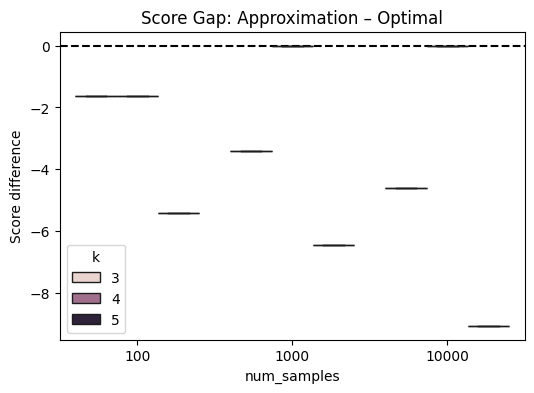

In [ ]:
asia_df = network_dfs["asia"]

In [14]:
column_order = [
    "num_samples",
    "seed",
    "l",
    "k",
    "runtime",
    "score",
    "dp_score",
    "optimal_upper_bound",
    "SHD",
]


In [15]:
# Sort globally before grouping
approx_df = approx_df.sort_values(["seed", "num_samples", "k"])

for net, df_net in approx_df.groupby("network"):
    print(f"% --- {net} ---")

    df_print = df_net.drop(columns=["network", "parent_map", "dp_parent_map", "num_vars"])

    df_print = df_print[column_order]

    # dynamically create column format string
    colfmt = "r" * len(df_print.columns)

    # generate the tabular
    tabular = df_print.to_latex(
        index=False,
        float_format="%.3f",
        column_format=colfmt,
        escape=False,
    )

    # wrap in table + resizebox
    print(
f"""\\begin{{table}}[H]
\\centering
\\scriptsize
\\caption{{Approximation algorithm vs DP on the {net} network.}}
\\label{{tab:approx_vs_dp_{net}}}
\\resizebox{{\\textwidth}}{{!}}{{%
{tabular}
}}
\\end{{table}}

"""
    )


% --- asia ---
\begin{table}[H]
\centering
\scriptsize
\caption{Approximation algorithm vs DP on the asia network.}
\label{tab:approx_vs_dp_asia}
\resizebox{\textwidth}{!}{%
\begin{tabular}{rrrrrrrrr}
\toprule
num_samples & seed & l & k & runtime & score & dp_score & optimal_upper_bound & SHD \\
\midrule
100 & 42 & 2 & 3 & 0.003 & -252.923 & -251.306 & -92.995 & 6 \\
100 & 42 & 2 & 4 & 0.005 & -252.923 & -251.306 & 66.933 & 4 \\
100 & 42 & 1 & 5 & 0.001 & -256.725 & -251.306 & 1007.490 & 11 \\
1000 & 42 & 2 & 3 & 0.005 & -2238.429 & -2235.024 & -573.288 & 4 \\
1000 & 42 & 2 & 4 & 0.005 & -2235.024 & -2235.024 & 1098.663 & 3 \\
1000 & 42 & 1 & 5 & 0.002 & -2241.466 & -2235.024 & 11067.515 & 10 \\
10000 & 42 & 2 & 3 & 0.007 & -22198.112 & -22193.508 & -5556.137 & 4 \\
10000 & 42 & 2 & 4 & 0.013 & -22193.508 & -22193.508 & 11095.047 & 3 \\
10000 & 42 & 1 & 5 & 0.003 & -22202.566 & -22193.508 & 110915.416 & 6 \\
100 & 43 & 2 & 3 & 0.007 & -252.923 & -251.306 & -92.995 & 6 \\
100 & 43 & 2 &

Generate network visualizations

In [16]:
from pgmpy.models import DiscreteBayesianNetwork

def draw_bn(pm, filename="bn.png"):
    # Convert pm into edge list
    edges = [(parent, child) for child, parents in pm.items() for parent in parents]
    bn = DiscreteBayesianNetwork(edges)

    # Convert model into pygraphviz object
    model_graphviz = bn.to_graphviz()

    # Plot the model.
    model_graphviz.draw(f"plots/{filename}", prog="dot")

In [17]:
asia = network_dfs["asia"]

In [18]:
for row_idx, row in asia.iterrows():
    k = row["k"]
    l = row["l"]
    seed = row["seed"]
    num_samples = row["num_samples"]
    filename = f"asia_k{k}_l{l}_seed{seed}_samples{num_samples}.png"
    draw_bn(row["parent_map"], filename=filename)

FileNotFoundError: [Errno 2] No such file or directory: 'plots/asia_k5_l1_seed44_samples1000.png'